# Word2Vec(CBOW)

In [0]:
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.font_manager as fm
import os

In [2]:
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
samples = ["창욱은 영화를 좋아한다",
          "창욱은 도서관을 좋아한다",
          "창욱은 공부를 좋아한다",
          "창욱은 축구를 좋아한다",
          "창욱은 수영을 좋아한다",
          "창욱은 야구를 좋아한다",
          "중현은 영화를 싫어한다", 
          "중현은 도서관을 싫어한다",
          "중현은 공부를 싫어한다", 
          "중현은 축구를 싫어한다", 
          "중현은 수영을 싫어한다", 
          "중현은 야구를 싫어한다"]

In [4]:
token_sentences = []

for sentence in samples:
  token_sentences.extend(sentence.split())

print("token_sentences : %s " %token_sentences)
word_list = " ".join(samples).split()
word_list = list(set(word_list))

print("word_list : %s" %word_list)

token_sentences : ['창욱은', '영화를', '좋아한다', '창욱은', '도서관을', '좋아한다', '창욱은', '공부를', '좋아한다', '창욱은', '축구를', '좋아한다', '창욱은', '수영을', '좋아한다', '창욱은', '야구를', '좋아한다', '중현은', '영화를', '싫어한다', '중현은', '도서관을', '싫어한다', '중현은', '공부를', '싫어한다', '중현은', '축구를', '싫어한다', '중현은', '수영을', '싫어한다', '중현은', '야구를', '싫어한다'] 
word_list : ['좋아한다', '야구를', '싫어한다', '도서관을', '중현은', '창욱은', '수영을', '공부를', '영화를', '축구를']


In [5]:
char_to_int = dict((c, i) for i, c in enumerate(word_list))
print(char_to_int)

{'좋아한다': 0, '야구를': 1, '싫어한다': 2, '도서관을': 3, '중현은': 4, '창욱은': 5, '수영을': 6, '공부를': 7, '영화를': 8, '축구를': 9}


In [6]:
int_to_char = dict((i, c) for i, c in enumerate(word_list))
print(int_to_char)

{0: '좋아한다', 1: '야구를', 2: '싫어한다', 3: '도서관을', 4: '중현은', 5: '창욱은', 6: '수영을', 7: '공부를', 8: '영화를', 9: '축구를'}


In [8]:
cbow = []
print(word_list)
print(token_sentences)

for i in range(1, len(token_sentences) - 1):
    target = char_to_int[token_sentences[i]]
    context = [char_to_int[token_sentences[i - 1]], char_to_int[token_sentences[i + 1]]]
    cbow.append([target, context])
        
print(cbow)

['좋아한다', '야구를', '싫어한다', '도서관을', '중현은', '창욱은', '수영을', '공부를', '영화를', '축구를']
['창욱은', '영화를', '좋아한다', '창욱은', '도서관을', '좋아한다', '창욱은', '공부를', '좋아한다', '창욱은', '축구를', '좋아한다', '창욱은', '수영을', '좋아한다', '창욱은', '야구를', '좋아한다', '중현은', '영화를', '싫어한다', '중현은', '도서관을', '싫어한다', '중현은', '공부를', '싫어한다', '중현은', '축구를', '싫어한다', '중현은', '수영을', '싫어한다', '중현은', '야구를', '싫어한다']
[[8, [5, 0]], [0, [8, 5]], [5, [0, 3]], [3, [5, 0]], [0, [3, 5]], [5, [0, 7]], [7, [5, 0]], [0, [7, 5]], [5, [0, 9]], [9, [5, 0]], [0, [9, 5]], [5, [0, 6]], [6, [5, 0]], [0, [6, 5]], [5, [0, 1]], [1, [5, 0]], [0, [1, 4]], [4, [0, 8]], [8, [4, 2]], [2, [8, 4]], [4, [2, 3]], [3, [4, 2]], [2, [3, 4]], [4, [2, 7]], [7, [4, 2]], [2, [7, 4]], [4, [2, 9]], [9, [4, 2]], [2, [9, 4]], [4, [2, 6]], [6, [4, 2]], [2, [6, 4]], [4, [2, 1]], [1, [4, 2]]]


In [0]:
context_1 = []
context_2 = []
target = []
for i in range(len(cbow)):
  context_1.append(cbow[i][1][0])  # input1
  context_2.append(cbow[i][1][1])  # input2
  target.append(cbow[i][0])  # label

In [0]:
def rearrange(context_1, context_2, target):
    features = {"context_1": context_1, "context_2": context_2}
    return features, target

In [0]:
EPOCH_SIZE = 1500
BATCH_SIZE = 12

def train_input_fn():
  dataset = tf.data.Dataset.from_tensor_slices((context_1, context_2, target))
  dataset = dataset.repeat(EPOCH_SIZE)
  dataset = dataset.batch(BATCH_SIZE)
  dataset = dataset.shuffle(len(cbow))
  dataset = dataset.map(rearrange)
  iterator = dataset.make_one_shot_iterator()
  
  return iterator.get_next()

In [0]:
VOCAB_SIZE = len(int_to_char)
EMB_SIZE = 2

def model_fn(features, labels, mode):
    TRAIN = mode == tf.estimator.ModeKeys.TRAIN
    EVAL = mode == tf.estimator.ModeKeys.EVAL
    
    w_1 = tf.Variable(tf.random_uniform([VOCAB_SIZE, EMB_SIZE], -1.0, 1.0)) #(10, 2)
    w_2 = tf.Variable(tf.random_uniform([EMB_SIZE, VOCAB_SIZE], -1.0, 1.0)) #(2, 10)

    input1 = tf.one_hot(indices=features['context_1'], depth=VOCAB_SIZE) #(?, 10)
    input2 = tf.one_hot(indices=features['context_2'], depth=VOCAB_SIZE) #(?, 10)

    h_1 = tf.matmul(input1, w_1) # (?, 10)*(10, 2) = (?, 2)
    h_2 = tf.matmul(input2, w_1) # (?, 10)*(10, 2) = (?, 2)
    hidden = h_1 + h_2 / 2 # (?, 2)

    output = tf.matmul(hidden, w_2) # (?, 2)*(2, 10) = (?, 10)
                                   
    targets = tf.one_hot(indices=labels, depth=VOCAB_SIZE)  
                                                            
    loss = tf.losses.softmax_cross_entropy(targets, output)
    print(loss)
    if TRAIN:
        global_step = tf.train.get_global_step()
        train_op = tf.train.AdamOptimizer(1e-3).minimize(loss, global_step)


    return tf.estimator.EstimatorSpec(
          mode=mode,
          train_op=train_op,
          loss=loss)

In [13]:
!rm -rf data_out;ls;

adc.json  gdrive  sample_data


In [14]:
DATA_OUT_PATH = './data_out/'

if not os.path.exists(DATA_OUT_PATH):
    os.makedirs(DATA_OUT_PATH)

estimator = tf.estimator.Estimator(model_fn = model_fn, model_dir = DATA_OUT_PATH + 'checkpoint/cbow')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': './data_out/checkpoint/cbow', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f9bd7c81198>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [15]:
estimator.train(train_input_fn)

Instructions for updating:
Colocations handled automatically by placer.
INFO:tensorflow:Calling model_fn.
Instructions for updating:
Use tf.cast instead.
Tensor("softmax_cross_entropy_loss/value:0", shape=(), dtype=float32)
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into ./data_out/checkpoint/cbow/model.ckpt.
INFO:tensorflow:loss = 2.5915334, step = 0
INFO:tensorflow:global_step/sec: 527.339
INFO:tensorflow:loss = 2.5286512, step = 100 (0.192 sec)
INFO:tensorflow:global_step/sec: 681.432
INFO:tensorflow:loss = 2.3878765, step = 200 (0.146 sec)
INFO:tensorflow:global_step/sec: 683.748
INFO:tensorflow:loss = 2.2582738, step = 300 (0.148 sec)
INFO:tensorflow:global_step/sec: 693.757
INFO:tensorflow:loss = 2.0664215, step = 400 (0.144 sec)
INFO:tensorflow:global_step/sec: 696.367
INFO:tensorf

In [0]:
variable_names = estimator.get_variable_names()

In [17]:
variable_names

['Variable',
 'Variable/Adam',
 'Variable/Adam_1',
 'Variable_1',
 'Variable_1/Adam',
 'Variable_1/Adam_1',
 'beta1_power',
 'beta2_power',
 'global_step']

In [0]:
emb1 = estimator.get_variable_value(variable_names[0])
emb2 = estimator.get_variable_value(variable_names[1])

In [30]:
emb1

array([[ 3.0487392 ,  1.1303236 ],
       [-0.7515838 , -1.2398534 ],
       [ 2.8983827 , -2.230506  ],
       [-0.7934759 , -0.05782174],
       [-1.419003  ,  1.376866  ],
       [-1.3371073 , -0.7629288 ],
       [-1.1285473 ,  0.10804669],
       [-1.123646  ,  0.10553578],
       [-1.0261726 , -0.20498887],
       [-0.70911103, -0.08945656]], dtype=float32)

In [19]:
emb = emb1
emb

array([[ 3.0416033 ,  1.1106247 ],
       [-0.75128466, -1.2392001 ],
       [ 2.8824754 , -2.205917  ],
       [-0.78638816, -0.05951404],
       [-1.4203346 ,  1.3866599 ],
       [-1.3261427 , -0.76540005],
       [-1.1261303 ,  0.10566265],
       [-1.11866   ,  0.11262929],
       [-1.0234476 , -0.20047553],
       [-0.70261306, -0.0973033 ]], dtype=float32)

###한글 폰드 설정

In [20]:
%matplotlib inline  

import matplotlib as mpl  
import matplotlib.pyplot as plt  
import matplotlib.font_manager as fm  

print(mpl.__version__)
print(mpl.__file__)
print(mpl.get_configdir())
print(mpl.get_cachedir())

3.0.3
/usr/local/lib/python3.6/dist-packages/matplotlib/__init__.py
/root/.config/matplotlib
/root/.cache/matplotlib


In [21]:
sys_font=fm.findSystemFonts()
print(f"sys_font number: {len(sys_font)}")
print(sys_font)

nanum_font = [f for f in sys_font if 'Nanum' in f]
print(f"nanum_font number: {len(nanum_font)}")

sys_font number: 16
['/usr/share/fonts/truetype/liberation/LiberationMono-Italic.ttf', '/usr/share/fonts/truetype/liberation/LiberationSans-Italic.ttf', '/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf', '/usr/share/fonts/truetype/liberation/LiberationSans-Regular.ttf', '/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Bold.ttf', '/usr/share/fonts/truetype/liberation/LiberationMono-BoldItalic.ttf', '/usr/share/fonts/truetype/liberation/LiberationSerif-Regular.ttf', '/usr/share/fonts/truetype/liberation/LiberationSans-BoldItalic.ttf', '/usr/share/fonts/truetype/liberation/LiberationSansNarrow-BoldItalic.ttf', '/usr/share/fonts/truetype/liberation/LiberationSerif-Bold.ttf', '/usr/share/fonts/truetype/liberation/LiberationMono-Regular.ttf', '/usr/share/fonts/truetype/liberation/LiberationSerif-BoldItalic.ttf', '/usr/share/fonts/truetype/liberation/LiberationSerif-Italic.ttf', '/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Italic.ttf', '/usr/share

In [22]:
!apt-get update -qq #나눔고딕 인스톨
!apt-get install fonts-nanum* -qq


sys_font=fm.findSystemFonts()
print(f"sys_font number: {len(sys_font)}")

nanum_font = [f for f in sys_font if 'Nanum' in f]
print(f"nanum_font number: {len(nanum_font)}")

Selecting previously unselected package fonts-nanum.
(Reading database ... 130912 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20170925-1_all.deb ...
Unpacking fonts-nanum (20170925-1) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-6_all.deb ...
Unpacking fonts-nanum-eco (1.000-6) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20170925-1_all.deb ...
Unpacking fonts-nanum-extra (20170925-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-1_all.deb ...
Unpacking fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-extra (20170925-1) ...
Setting up fonts-nanum (20170925-1) ...
Setting up fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-eco (1.000-6) ...
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...
sys_font number: 47
nanum_font number: 31


In [23]:
nanum_font

['/usr/share/fonts/truetype/nanum/NanumBarunpenR.ttf',
 '/usr/share/fonts/truetype/nanum/NanumSquareRoundL.ttf',
 '/usr/share/fonts/truetype/nanum/NanumSquareL.ttf',
 '/usr/share/fonts/truetype/nanum/NanumGothicCoding.ttf',
 '/usr/share/fonts/truetype/nanum/NanumBarunGothicUltraLight.ttf',
 '/usr/share/fonts/truetype/nanum/NanumMyeongjoEcoExtraBold.ttf',
 '/usr/share/fonts/truetype/nanum/NanumGothic.ttf',
 '/usr/share/fonts/truetype/nanum/NanumSquareEB.ttf',
 '/usr/share/fonts/truetype/nanum/NanumBarunGothicLight.ttf',
 '/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf',
 '/usr/share/fonts/truetype/nanum/NanumPen.ttf',
 '/usr/share/fonts/truetype/nanum/NanumBarunGothicBold.ttf',
 '/usr/share/fonts/truetype/nanum/NanumMyeongjoEco.ttf',
 '/usr/share/fonts/truetype/nanum/NanumGothicCoding-Bold.ttf',
 '/usr/share/fonts/truetype/nanum/NanumSquareB.ttf',
 '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf',
 '/usr/share/fonts/truetype/nanum/NanumMyeongjo.ttf',
 '/usr/share/fonts/truety

In [24]:
!python --version
def current_font():
  print(f"설정 폰트 글꼴: {plt.rcParams['font.family']}, 설정 폰트 사이즈: {plt.rcParams['font.size']}")  # 파이썬 3.6 이상 사용가능하다
        
current_font()

Python 3.6.7
설정 폰트 글꼴: ['sans-serif'], 설정 폰트 사이즈: 10.0


In [25]:
path = '/usr/share/fonts/truetype/nanum/NanumGothicEco.ttf'  
font_name = fm.FontProperties(fname=path, size=10).get_name()
print(font_name)
plt.rc('font', family=font_name)

NanumGothic Eco


In [0]:
fm._rebuild()

In [0]:
matplotlib.rcParams['axes.unicode_minus'] = False

### 임베딩 그림 그리기

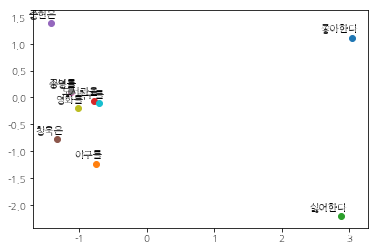

In [28]:
for i, label in enumerate(word_list):
    x, y = emb[i]
    plt.scatter(x, y)
    plt.annotate(label, xy=(x, y), xytext=(6, 4),
                 textcoords='offset points', ha='right', va='bottom')

plt.show()